Import libraries

In [1]:
!git clone https://github.com/ChrisYang/facefrontalisation.git

Cloning into 'facefrontalisation'...
remote: Enumerating objects: 19, done.
remote: Total 19 (delta 0), reused 0 (delta 0), pack-reused 19
Unpacking objects: 100% (19/19), 2.61 MiB | 3.67 MiB/s, done.


In [2]:
!wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bunzip2 /content/shape_predictor_68_face_landmarks.dat.bz2


--2023-06-04 09:53:15--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  14.7MB/s    in 6.6s    

2023-06-04 09:53:22 (9.28 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [3]:
!pip install --upgrade dlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 67.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dlib: filename=dlib-19.24.2-cp310-cp310-linux_x86_64.whl size=4164654 sha256=b2f601e89e4d5756f3864bb4e12ec827803a10547f71ad90ce8ca3906073c9d5
  Stored in directory: /root/.cache/pip/wheels/9b/e2/80/888fdc098db86b463ff0c83ae5e5ca151889e901bc1e9a3a11
Successfully built dlib
  Attempting uninstall: dlib
    Found existing installation: dlib 19.24.1
    Uninstalling dlib-19.24.1:
      Successfully uninstalled dlib-19.24.1


If the image doesnt fit it into 8gb rgb then you can convert it into 8gb rgb

In [15]:
from PIL import Image

def convert_to_8bit_rgb(image_path):
    try:
        img = Image.open(image_path)
        img = img.convert("RGB")
        img = img.quantize(colors=256)
        img = img.convert("L")  # Convert to 8-bit grayscale
        img = img.convert("RGB")  # Convert back to RGB
        img.save("/content/facefrontalisation/test2.jpg")
        print("Image converted to 8-bit RGB format.")
    except IOError:
        print("Unable to open or convert the image.")

# Provide the path to your image
image_path = "/content/facefrontalisation/202_01_01_050_06_cropped_test(1).png"

# Convert the image to 8-bit RGB
convert_to_8bit_rgb(image_path)


Image converted to 8-bit RGB format.


<ipython-input-17-eb083aec539e>:50: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p3_ = np.reshape(self.p3d,(-1,3,1)).astype(np.float)
<ipython-input-17-eb083aec539e>:51: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p2_ = np.reshape(p2d,(-1,2,1)).astype(np.float)
<ipython-input-17-eb083aec539e>:96: DeprecationWarning: `np.float` is a dep

-5290.090292918398
eplased time: 0.059366464614868164


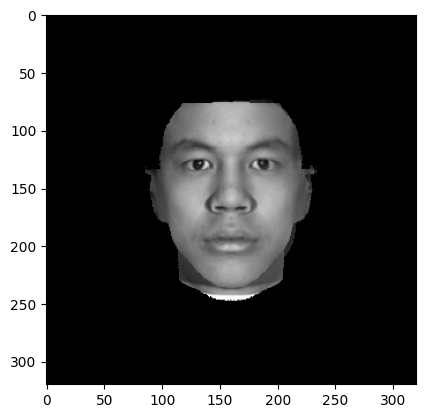

In [17]:
'''
This is the python code as a re-implementation of the matlab code from:
http://www.openu.ac.il/home/hassner/projects/frontalize/
Tal Hassner, Shai Harel*, Eran Paz* and Roee Enbar, Effective Face Frontalization in Unconstrained Images, IEEE Conf. on Computer Vision and Pattern Recognition (CVPR), Boston, June 2015
The algorithm credit belongs to them. 
I implement it as I dislike reading matlab code--i started using matlab when it was around 1GB but look at it now.....
In order to make the code run you need: 
1. compile the dlib python code: http://dlib.net/
2. download the shape_predictor_68_face_landmarks.dat file from:
http://sourceforge.net/projects/dclib/files/dlib/v18.10/shape_predictor_68_face_landmarks.dat.bz2
3. install python dependencies 
Contact me if you have problem using this code: 
heng.yang@cl.cam.ac.uk 
'''

import scipy.misc as sm
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import dlib
import pickle as pkl
import time 
from scipy import ndimage
import copy 


def plot3d(p3ds):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(p3ds[:,0],p3ds[:,1], p3ds[:,2])
    plt.show()


class frontalizer():
    def __init__(self,refname):
        # initialise the model with the 3d reference face 
        # and the camera intrinsic parameters 
        # they are stored in the ref3d.pkl  
        with open(refname , 'rb') as f:
            ref = pkl.load(f , encoding='latin')
            self.refU  = ref['refU']
            self.A = ref['outA']
            self.refxy = ref['ref_XY']
            self.p3d = ref['p3d']
            self.refimg = ref['refimg']
    def get_headpose(self,p2d):
        assert(len(p2d) == len(self.p3d))
        p3_ = np.reshape(self.p3d,(-1,3,1)).astype(np.float)
        p2_ = np.reshape(p2d,(-1,2,1)).astype(np.float)
        distCoeffs = np.zeros((5,1))
        succ,rvec,tvec = cv2.solvePnP(p3_,p2_, self.A, distCoeffs)
        if not succ:
            print('There is something wrong, please check.')
            return None
        else:
            matx = cv2.Rodrigues(rvec)
            ProjM_ = self.A.dot(np.insert(matx[0],3,tvec.T,axis=1))
            return rvec,tvec,ProjM_
    def frontalization(self,img_,facebb,p2d_):
        #we rescale the face region (twice as big as the detected face) before applying frontalisation
        #the rescaled size is WD x HT 
        WD = 250 
        HT = 250 
        ACC_CONST = 800
        facebb = [facebb.left(), facebb.top(), facebb.width(), facebb.height()]
        w = facebb[2]
        h = facebb[3]
        fb_ = np.clip([[facebb[0] - w, facebb[1] - h],[facebb[0] + 2 * w, facebb[1] + 2 * h]], [0,0], [img_.shape[1], img_.shape[0]])  
        img = img_[fb_[0][1]:fb_[1][1], fb_[0][0]:fb_[1][0],:]
        p2d = copy.deepcopy(p2d_) 
        p2d[:,0] = (p2d_[:,0] - fb_[0][0]) * float(WD) / float(img.shape[1])
        p2d[:,1] = (p2d_[:,1] - fb_[0][1])  * float(HT) / float(img.shape[0])
        img = cv2.resize(img, (WD,HT)) 
        #finished rescaling
       
        tem3d = np.reshape(self.refU,(-1,3),order='F')
        bgids = tem3d[:,1] < 0# excluding background 3d points 
        # plot3d(tem3d)
        # print tem3d.shape 
        ref3dface = np.insert(tem3d, 3, np.ones(len(tem3d)),axis=1).T
        ProjM = self.get_headpose(p2d)[2]
        proj3d = ProjM.dot(ref3dface)
        proj3d[0] /= proj3d[2] 
        proj3d[1] /= proj3d[2]
        proj2dtmp = proj3d[0:2]
        #The 3D reference is projected to the 2D region by the estimated pose 
        #The check the projection lies in the image or not 
        vlids = np.logical_and(np.logical_and(proj2dtmp[0] > 0, proj2dtmp[1] > 0), 
                               np.logical_and(proj2dtmp[0] < img.shape[1] - 1,  proj2dtmp[1] < img.shape[0] - 1))
        vlids = np.logical_and(vlids, bgids)
        proj2d_valid = proj2dtmp[:,vlids]

        sp_  = self.refU.shape[0:2]
        synth_front = np.zeros(sp_,np.float)
        inds = np.ravel_multi_index(np.round(proj2d_valid).astype(int),(img.shape[1], img.shape[0]),order = 'F')
        unqeles, unqinds, inverids, conts  = np.unique(inds, return_index=True, return_inverse=True, return_counts=True)
        tmp_ = synth_front.flatten()
        tmp_[vlids] = conts[inverids].astype(np.float)
        synth_front = tmp_.reshape(synth_front.shape,order='F')
        synth_front = cv2.GaussianBlur(synth_front, (17,17), 30).astype(np.float)

        rawfrontal = np.zeros((self.refU.shape[0],self.refU.shape[1], 3)) 
        for k in range(3):
            z = img[:,:,k]
            intervalues = ndimage.map_coordinates(img[:,:,k].T,proj2d_valid,order=3,mode='nearest')
            tmp_  = rawfrontal[:,:,k].flatten()
            tmp_[vlids] = intervalues
            rawfrontal[:,:,k] = tmp_.reshape(self.refU.shape[0:2],order='F')

        mline = synth_front.shape[1]//2
        sumleft = np.sum(synth_front[:,0:mline])
        sumright = np.sum(synth_front[:,mline:])
        sum_diff = sumleft - sumright
        print (sum_diff)
        if np.abs(sum_diff) > ACC_CONST:
            weights = np.zeros(sp_)
            if sum_diff > ACC_CONST:
                weights[:,mline:] = 1.
            else:
                weights[:,0:mline] = 1.
            weights = cv2.GaussianBlur(weights, (33,33), 60.5).astype(np.float)
            synth_front /= np.max(synth_front) 
            weight_take_from_org = 1 / np.exp(1 + synth_front)
            weight_take_from_sym = 1 - weight_take_from_org
            weight_take_from_org = weight_take_from_org * np.fliplr(weights)
            weight_take_from_sym = weight_take_from_sym * np.fliplr(weights) 
            weights = np.tile(weights,(1,3)).reshape((weights.shape[0],weights.shape[1],3),order='F')
            weight_take_from_org = np.tile(weight_take_from_org,(1,3)).reshape((weight_take_from_org.shape[0],weight_take_from_org.shape[1],3),order='F')
            weight_take_from_sym = np.tile(weight_take_from_sym,(1,3)).reshape((weight_take_from_sym.shape[0],weight_take_from_sym.shape[1],3),order='F')
            denominator = weights + weight_take_from_org + weight_take_from_sym
            frontal_sym = (rawfrontal * weights + rawfrontal * weight_take_from_org + np.fliplr(rawfrontal) * weight_take_from_sym) / denominator
        else:
            frontal_sym = rawfrontal
        return rawfrontal, frontal_sym


if __name__ == "__main__":
    ##to make sure you have dlib 
    PATH_face_model = '/content/shape_predictor_68_face_landmarks.dat'
    md_face = dlib.shape_predictor(PATH_face_model)
    face_det = dlib.get_frontal_face_detector()
    fronter = frontalizer('/content/facefrontalisation/ref3d.pkl')
    #________________model initialisation 
    #

    # test your image 
    img_name = '/content/facefrontalisation/test2.jpg'#names[k]
    img = plt.imread(img_name)
    facedets = face_det(img,1)
    for det in facedets:
        shape = md_face(img,det)
        p2d = np.asarray([(shape.part(n).x, shape.part(n).y,) for n in range(shape.num_parts)], np.float32)
    st = time.time()
    rawfront, symfront = fronter.frontalization(img,det,p2d)
    print ("eplased time:", time.time() - st) 
    plt.imshow(np.round(symfront).astype(np.uint8))
    plt.show()
    